# Exercise "Lecture 14: Neural Classification"


In this set of exercises, we will use a Recurrent Neural Network to classify BBC news articles into 5 topics. The dataset consists of 2225 documents and 5 categories: business, entertainment, politics, sport, and technology. 


The exercises cover the following points:

* Converting the text in the corpus to vectors of integers (each integer represents a word in the corpus vocabulary)
* Computing some descriptive statistics to identify a sentence length cutoff (sentences with longer lengths will not be considered for training)
* Specifying, training and testing a recurrent neural network 

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preprocessing (PROVIDED)

We first prepocessed the data to extract X (the input) and Y (the input labels)

In [95]:
import pandas as pd
from sklearn.datasets import load_files


# for reproducibility
random_state = 0 

DATA_DIR = "/content/drive/MyDrive/NLP Masters/M2/Data Science/Data Science Labs/14/bbc/"
data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace", random_state=random_state)


df = pd.DataFrame({'news_report': data['data'], 'labels': data['target']})
# add text labels 
df['labels_text'] = df.labels.apply(lambda x: data['target_names'][x])
df.head()


,news_report,labels,labels_text
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,0,business
1,Halo 2 sells five million copies\n\nMicrosoft ...,4,tech
2,MSPs hear renewed climate warning\n\nClimate c...,2,politics
3,Pavey focuses on indoor success\n\nJo Pavey wi...,3,sport
4,Tories reject rethink on axed MP\n\nSacked MP ...,2,politics


Extracting X (texts) and Y (classes)

In [96]:
texts = df["news_report"]
labels = df["labels"]

n=100
print(texts[n])
print(labels[n])

Spain coach faces racism inquiry

Spain's Football Federation has initiated disciplinary action against national coach Luis Aragones over racist comments about Thierry Henry.

If found guilty Aragones could lose his job or face a fine of about £22,000. The federation had initially declined to take action against Aragones after comments he made during a national team training session in October. But its president Angel Maria Villar changed his mind after a request by Spain's anti-violence commission. Aragones insisted the comments, made to Henry's Arsenal club-mate Jose Antonio Reyes, were meant to motivate the player, and were not intended to be offensive.

"I never intended to offend anyone, and for that reason I have a very easy conscience," he said at the time. "I'm obliged to motivate my players to get the best results. "As part of that job, I use colloquial language, with which we can all understand each other within the framework of the football world. " England's players made a 

### 2 Converting the texts in the corpus to vectors of integers 

#### Exercise 1 -  Convert the corpus to a list of lists of integers

* Define a dictionary tokens2int which maps each distinct token in the corpus to a distinct integer 
(the size of this dictionary is the size of the corpus vocabulary i.e., the number of distinct tokens in the corpus, cf. Python CS)
* Use this dictionary to map each news report to a vector.


**Example**
* Input Texts: ["The woman put the book on the table", "The woman reads"]
* Created vocabulary: {the, woman, put, book, on, table, reads}
* Output Texts: [ [1,2,3,1,4,5,1,6], [1,2,7]]



In [97]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [98]:
import collections
from nltk import word_tokenize
## Set the size of the default value that will be assigned to each token to 
## the current size of the vocabulary
token2int = collections.defaultdict(lambda: len(token2int)+1) 

# Create the dictionary from a list of tokens
tokenized_texts = [word_tokenize(text) for text in texts]
int_texts = [[token2int[token.lower()] for token in text] for text in tokenized_texts]

token2int

defaultdict(<function __main__.<lambda>()>,
            {'tate': 1,
             '&': 2,
             'lyle': 3,
             'boss': 4,
             'bags': 5,
             'top': 6,
             'award': 7,
             "'s": 8,
             'chief': 9,
             'executive': 10,
             'has': 11,
             'been': 12,
             'named': 13,
             'european': 14,
             'businessman': 15,
             'of': 16,
             'the': 17,
             'year': 18,
             'by': 19,
             'a': 20,
             'leading': 21,
             'business': 22,
             'magazine': 23,
             '.': 24,
             'iain': 25,
             'ferguson': 26,
             'was': 27,
             'awarded': 28,
             'title': 29,
             'us': 30,
             'publication': 31,
             'forbes': 32,
             'for': 33,
             'returning': 34,
             'one': 35,
             'uk': 36,
             '``': 37,
             'v

#### Exercise 2 - Define the reverse int2token mapping and check the token2int and the int2token mappings on an example

* Check that the words have been correctly converted to integer by applying the reverse integer to token mapping
* Print out the vocabulary size 
* Print out the maximum text length 


In [99]:
int2token = dict()
for key, value in token2int.items():
    int2token[value] = key

## Exemple to check if it performs correctly
print(token2int['horse'])
print(int2token[1604])

## Vocabulary Size:
print("The Vocabulary size is:",len(token2int))

## Maximum text length
text_lengths = [len(text) for text in tokenized_texts]
print("The maximum text length:", max(text_lengths))

1604
horse
The Vocabulary size is: 34594
The maximum text length: 4969


#### Exercise 3 - Compute some statistics to determine which sentences to keep

The maximum sentence size is very large (4432 tokens). Presumably most reports are not that long. Use pandas describe() method and matplotlib to get a better idea of the data distribution in terms of report length.

* Compute the list of report lengths (list of nb of tokens for each report in the BBC news corpus)
* Compute the box plots for report lengths
* Use pandas describe() method to get the descripte statistics (min, max, means, etc.)

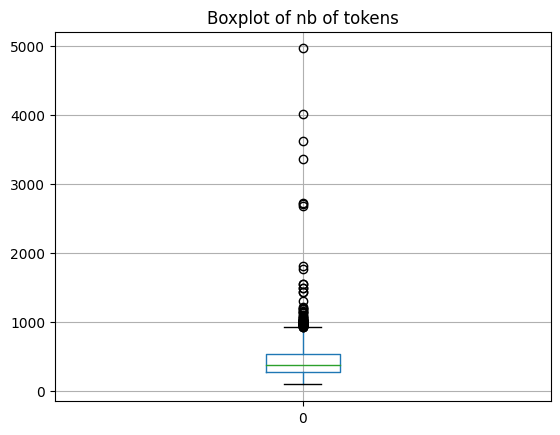

,0
count,2225.000000
mean,438.204045
std,269.705388
min,98.000000
25%,280.000000
50%,380.000000
75%,538.000000
max,4969.000000


In [117]:
import matplotlib.pyplot as plt
df1 = pd.DataFrame(text_lengths)

## BOXPLOT:
df1.boxplot()
plt.title("Boxplot of nb of tokens")
plt.show()

## Description of the data
df1.describe()

### 2  Classifying with a Recurrent Neural Network

We import some pytorch submodules (PROVIDED)

* torch: functions to create tensors and operations on tensors 
* torch.nn: to specify neural networks
* torch.nn.functional for when we want to define a custom layer for example with a convolution operation layer.
* torch.optim: optimizers for training 

We also need to specify some constants which ensure that the code can run on CPU. The `max_len` constant is important as text whose size exceeds (in number of tokens) that limit will be discarded. We set it to 555 (see next). 

In [101]:
!python -m pip install torch==2.0.0 torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Exercise 4 - Creating tensors

To help speed up computation, all data must be converted to tensors. 

* Set the maximum size of text to the 3rd quartile (555)
* Create a tensor of size  (number of texts, maximum size of a text) for X. Call this tensor X. Longer texts will be cut down to maximal size and shorter texts will be padded with `<eos>`. Use torch.zeros method and make sure to specify the components will be of type integer (long attribute in torch)
* Populate this matrix with the integer version of the BBC news report (cf. Exercise 1). Use the torch.LongTensor method. When populating the matrix cut down sentence whose length is above the max length to max length
* Create another tensor of size (numbers of text) and populate it with the list of labels. Call this tensor Y.
* Print out the shape of X and Y . X should be of size (2225, 555) and Y of size (2225,) 

N.B. In practice, it is not necessary to have all the data in a single tensor. In fact, this is inefficient if the texts have varied length. The only constraint is that for a given batch, all sequences have the same size. 

In [103]:
## Specifying the maximum length, which is equivalent to the 3rd quartile.
## We should pay attention that the value of the third quartile is 538, 
## while in the given it was specified as 555

max_len = 555

## Tensor is the equivalent of pytorch of a list/table/matrix with multiple
## dimensions
## We create the table of dimentsion  and we fill it with 0
X = torch.zeros(len(texts), max_len, dtype=torch.long)
## print(X.size()) # To check the length
## print(X) # et To check the content

## We fill the tensor line with the text  line converted to natural numbers
for i, int_text in enumerate(int_texts): ## For each text
    if len(int_text) < max_len: ## In case the text is too short.
        int_text = int_text + [len(token2int)] * (max_len - len(int_text))
        ## We obtain the best length

    X[i] = torch.LongTensor(int_text[:max_len]) ## fill the corresponding rows.

## Create another tensor of size (numbers of text) and populate it with
##  the list of labels. Call this tensor Y.
Y = torch.LongTensor(labels)

## Print out the shape of X and Y . X should be of size (2225, 555) 
## and Y of size (2225,) 
print(X.size())
print(Y.size())

torch.Size([2225, 555])
torch.Size([2225])


#### Exercise 5 - Create train and test data

* Split X into two parts, one called X_train which consists of the first 1112 items and the other called X_valid which includes the rest of the data
* Do the same for Y

In [104]:
X_train = X[:1112]
Y_train = Y[:1112]

X_valid = X[1112:]
Y_valid = Y[1112:]

#### Create batches with DataLoader (PROVIDED)

pytorch provides a batch generator which shuffles the data. We apply it to train and validation data

In [105]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 32
# the TensorDataset is a ready to use class to represent your data as list of tensors. 
# Note that input_features and labels must match on the length of the first dimension
train_set = TensorDataset(X_train, Y_train)
valid_set = TensorDataset(X_valid, Y_valid)

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

#### Exercise 6 - Define your neural network (PARTIALLY PROVIDED)

We define a network by specifying a subclass of the appropriate pytorch modules. For instance here, as we want to create an RNN we create a subclass of pytorch RNN module. The specification of the network falls into 2 parts. 

In the init part, the layers of the network are defined and  their type and shape are specified.  

In the forward part, we connect the layers and specify input and output for each layer. 
 
* The hidden state returned by the GRU layer is of size (num_layers * num_directions, batch_size, hidden_size) 
* The input to the decision layer should be of size (batch_size, hidden_size).   

Hence the first 2 dimensions of hidden must be transposed and the tensor redimensioned to (batch_size, hidden_size).

* drop : (num_layers * num_directions, batch_size, hidden_size)
* drop.transpose(0,1): (batch_size, num_layers * num_directions,  hidden_size)
* x.size(0) = batch_size
* drop.transpose(0,1).contiguous.view(x.size(0), -1): (batchsize, hiddensize)

**TODO:** fill in the missing variables (marked by ???)

In [123]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super().__init__()
        
        # Here we define the network layers
        
        # An embedding layer projecting vectors of size vocab_size into embeddings of size embed_size
        # Assigns to each word in the vocabulary an embedding of size embed_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        # A recurrent (GRU) layer to process each input token (represented by its embedding)
        # The GRU network takes as input the embedding (of size embed_size) of the current word 
        # and the previous hidden state (of size hidden_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True) 
        
        # Drop out layer for regularisation
        self.dropout = nn.Dropout(0.3)
        
        # Fully connected layer mapping 
        # the last layer maps a hidden state to a vector of size the number of classes
        self.decision = nn.Linear(hidden_size, num_classes)
         
    def forward(self, x):
        # Here we say how the layers are connected 
       
        #  for each token in the input, retrieve the corresponding embeddings 
        
        # x = [batch size, input size]
        embed = self.embed(x)
        # embed = [batch size, sent len, emb dim]       
       
        # Run the RNN on the input embeddings
        # output is the sequence of hidden states produced by the RNN
        # hidden is the last hidden state produced
        output, hidden = self.rnn(embed)
        
        # output = [sent len, batch size, hidden size]
        # hidden = [num_layers * num_directions, batch size, hidden_size ]
        
        # Apply dropout (for regularisation)
        drop = self.dropout(hidden)
        
        # drop = [num_layers * num_directions, batch size, hidden_size]   
        
        # Apply the fully connected layer to the output of the dropout
        # Expected input size: [batch_size, input_size]
        # We transpose [num_layers * num_directions, batch size, hidden_size ]
        # to: [batch size, num_layers * num_directions, hidden_size ]
        # And apply view to create an input of the form [batch size, input_size ]
        # (x.size(0) = batch size)
        
        # effectively the same as with drop.squeeze(0)
        return self.decision(drop.view(x.size(0), -1))
    
rnn_model = RNN(vocab_size = len(token2int)+1, embed_size = 300, 
                hidden_size = 256, num_classes=len(df1[0].unique()))
device = torch.device('cpu')
rnn_model.to(device)

RNN(
  (embed): Embedding(34595, 300)
  (rnn): GRU(300, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=256, out_features=686, bias=True)
)

#### Exercise 7  - Evaluating (PARTIALLY PROVIDED)

We define an evaluation function (called "perf") which computes the average loss on the test/validation dataset and the proportion of correct cases. 

* We use pytorch nn.CrossEntropyLoss() as loss function.
* For each batch returned by the loader, we calculate the scores produced by the model for each class, the loss, the predictions and the loss.
* To block dropout (which should only be used at training time), we use the eval() method. 
* "with torch.no_grad()" temporarily set all the requires_grad flag to false. In practice, this enforces that gradients are not computed (and therefore the weights of the model remain unchanged). 

**TODO:** Modify the function so that it outputs the proportion of correct predictions in addition to the loss. Replace the '??' in the function with the correct variables and/or operations on these variables.


In [121]:
def perf(model, loader):
    ## Define the loss
    criterion = nn.CrossEntropyLoss()

    ## No drop out
    model.eval()
    total_loss, correct, num = 0, 0, 0
    correct_predictions, total_predictions = 0, 0
    for x, y in loader:
      ## No gradient computation, weights remain unchanged
      with torch.no_grad():
        ## Compute the scofed for the instances in the input batch.
        y_scores = model(x)
        ## compute the loss
        predictions = torch.argmax(y_scores, dim=1)
        ## compute the predictions
        correct_predictions += sum(predictions == y).item() 

        total_predictions += len(y) 
        loss = criterion(y_scores, y)
        y_pred = torch.max(y_scores, 1)[1]
        ## Update the batch loss.
        total_loss += loss.item()
        num += len(y)

    return total_loss / num, correct_predictions / total_predictions

In [124]:
perf(model = rnn_model, loader = valid_loader)

(0.20527846172706352, 0.0)

#### Exercise 8  - Training Loop

Define a function fit(model, epochs) which you will use to train your model

* use the CrossEntropyLoss and the Adam optimizer
* iterates over the epochs and for each epoch:
   - Set the module in training mode (use the train() method). Dropout will be enabled and gradients will be computed. 
   - Initialise the total loss to 0
   - Iterate over each batches returned by train_loader    
     For each batch:   
        - set the gradients to null (optimizer.zero_grad())
        - predicts the batch scores
        - calculate the loss
        - back propagate
        - optimize (adjust the weights)
        - update the total loss
   
**Hint:** Some of these steps are defined in the preceding exercise.

In [125]:
def fit(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        num_samples = 0
        
        for x_data, y_data in train_loader:
            x_data = x_data.to(device)
            y_data = y_data.to(device)
            optimizer.zero_grad()
            y_pred = model(x_data)
            num_samples += len(y_pred)
            loss = criterion(y_pred, y_data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        valid_loss, valid_acc = perf(model, valid_loader)
        print(f'Epoch {epoch + 1}/{epochs} | Train loss: {total_loss/num_samples:.4f} | Valid loss: {valid_loss:.4f} | Acc: {valid_acc:.4%}')


#### Exercise 9 - Training

Use the fit function you just defined to train your model. 
* The loss function on the train and validation set should decrease
* The accuracy on the validation set should improve

In [ ]:
## Running this code will take a lot of time
fit(rnn_model, 10)

Epoch 1/10 | Train loss: 0.0508 | Valid loss: 0.0486 | Acc: 28.0323%


### 3 Classifying with a Convolutional Neural Network (OPTIONAL)

Here below is a CNN model definition. Run it on the data and compare the speed and results with that of the RNN.

In [127]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.1)
        self.decision = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        embed = self.embed(x)
        conv = F.relu(self.conv(embed.transpose(1,2)))
        pool = F.max_pool1d(conv, conv.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

cnn_model = CNN(vocab_size = len(token2int), embed_size = 64, 
                hidden_size = 128, num_classes=len(df1[0].unique()))
cnn_model.to(device)

CNN(
  (embed): Embedding(34594, 64)
  (conv): Conv1d(64, 128, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.1, inplace=False)
  (decision): Linear(in_features=128, out_features=686, bias=True)
)

In [130]:
cnn_model = CNN(vocab_size=len(token2int)+1, embed_size=64, hidden_size=128, num_classes=len(df.labels.unique()))
cnn_model.to(device)
fit(cnn_model, 25)

Epoch 1/25 | Train loss: 0.0500 | Valid loss: 0.0464 | Acc: 40.1617%
Epoch 2/25 | Train loss: 0.0410 | Valid loss: 0.0392 | Acc: 73.2255%
Epoch 3/25 | Train loss: 0.0337 | Valid loss: 0.0314 | Acc: 79.4250%
Epoch 4/25 | Train loss: 0.0250 | Valid loss: 0.0247 | Acc: 82.0305%
Epoch 5/25 | Train loss: 0.0185 | Valid loss: 0.0196 | Acc: 86.8823%
Epoch 6/25 | Train loss: 0.0145 | Valid loss: 0.0166 | Acc: 84.8158%
Epoch 7/25 | Train loss: 0.0114 | Valid loss: 0.0146 | Acc: 86.8823%
Epoch 8/25 | Train loss: 0.0096 | Valid loss: 0.0122 | Acc: 89.8473%
Epoch 9/25 | Train loss: 0.0077 | Valid loss: 0.0115 | Acc: 90.1168%
Epoch 10/25 | Train loss: 0.0060 | Valid loss: 0.0100 | Acc: 92.0934%
Epoch 11/25 | Train loss: 0.0050 | Valid loss: 0.0095 | Acc: 91.4645%
Epoch 12/25 | Train loss: 0.0043 | Valid loss: 0.0091 | Acc: 91.8239%
Epoch 13/25 | Train loss: 0.0037 | Valid loss: 0.0082 | Acc: 92.8122%
Epoch 14/25 | Train loss: 0.0030 | Valid loss: 0.0077 | Acc: 93.1716%
Epoch 15/25 | Train loss: 0.0